In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sns.set(style='whitegrid')
sys.path.append('..')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression, LogisticRegression
from load_data import *

### Load the data

In [48]:
df = load_dataset('../data/DataTrain.txt')
df = df.set_index('engine_id')

df = df[['cycle', 's11', 's4', 's12', 's7', 's15', 's21', 's20', 's17', 's2', 's3', 's13', 's8']]

df_test  = df[df.index > 90]
df_train = df[df.index <= 90]

### Get the remaining time for each engine

In [4]:
def get_ruls(dataframe):
    """
    Get the ruls of the engines
    """
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = (dataframe['max_cycle'] - dataframe['cycle'] + 1).values
    
    return ruls

df_train.loc[:, 'rul'] = get_ruls(df_train)
df_test.loc[:, 'rul']  = get_ruls(df_test)

df_train[['cycle', 'rul']].tail()

,cycle,rul
engine_id,,
90,150,5
90,151,4
90,152,3
90,153,2
90,154,1


### Plot the timeseries of the engines

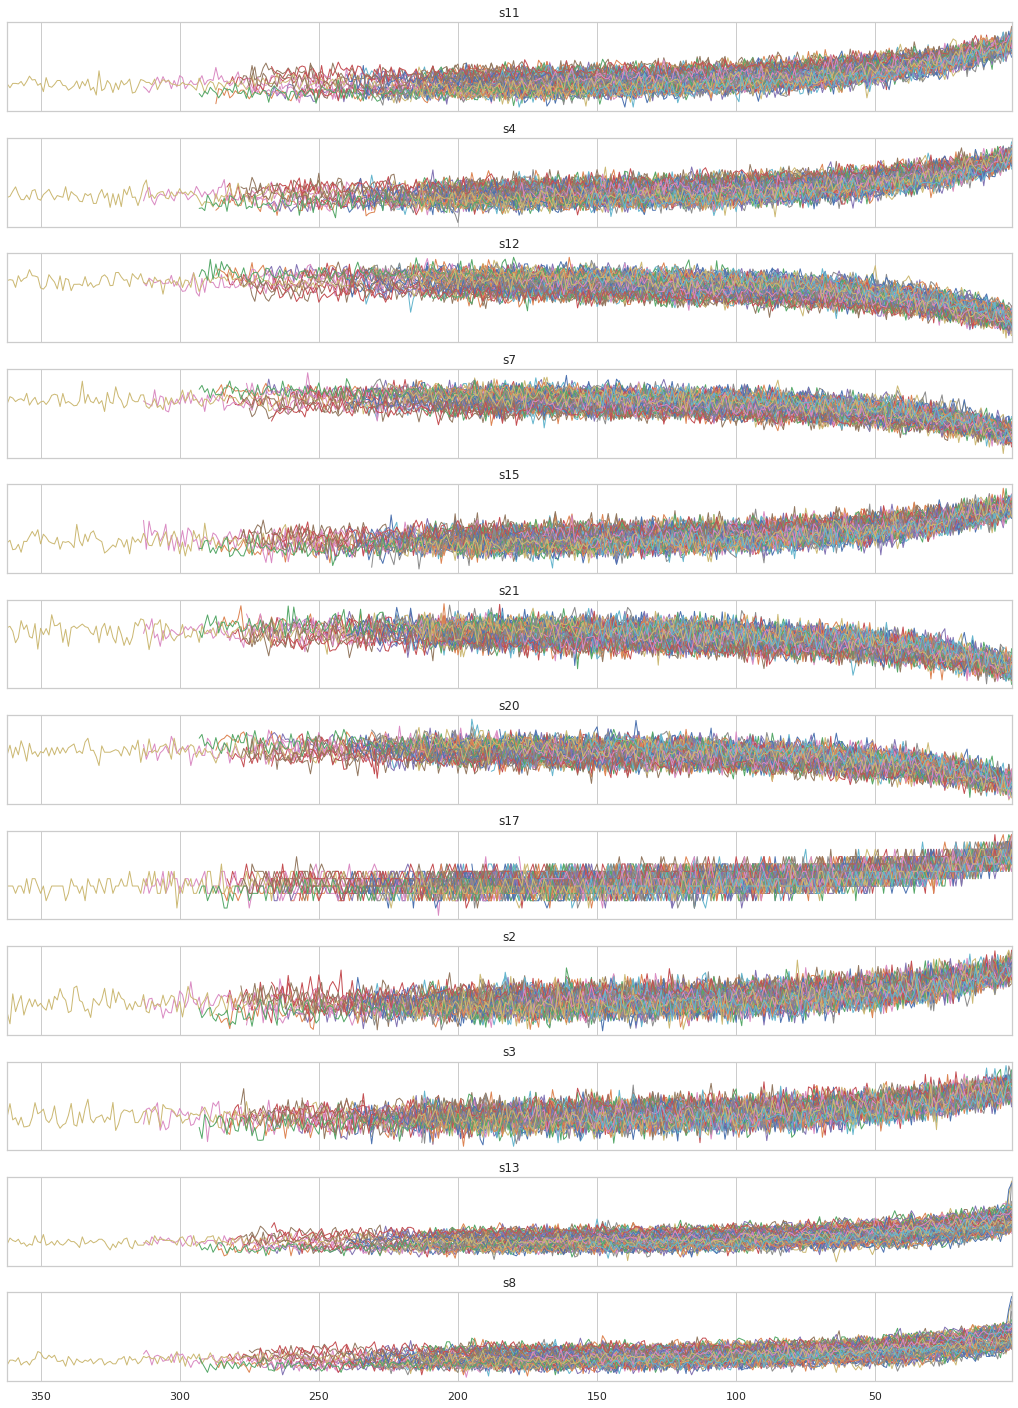

In [5]:
def plot_timeseries(dataframe):
    ts = dataframe.copy()
    
    max_rul = ts['rul'].max()
    
    ts.drop(labels=['cycle'], axis=1, inplace=True)

    cols = ts.columns
    fig, axes = plt.subplots(len(cols)-1, 1, figsize=(18,25), sharex=True)

    for col, ax in zip(cols, axes):
        if col == 'rul':
            continue

        ax.set_title(col, fontdict={'fontsize': 12})
        ax.set_xlim(max_rul, 1)
        ax.get_yaxis().set_visible(False)

        for engine_id in ts.index.unique():
            time = ts.loc[engine_id, 'rul']
            ax.plot(time, ts.loc[engine_id,col], label=col, linewidth=1)

    plt.subplots_adjust(hspace=0.3)
    
plot_timeseries(df_train)

### Normalize the sensors

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
df_train_norm = df_train.copy()
df_test_norm  = df_test.copy()

scaler = StandardScaler()

df_train_norm.iloc[:, 1:-1] = scaler.fit_transform(df_train.iloc[:, 1:-1])
df_test_norm.iloc[:, 1:-1]  = scaler.transform(df_test.iloc[:, 1:-1])

df_train_norm.head()

,cycle,s11,s4,s12,s7,s15,s21,s20,s17,s2,s3,s13,s8,rul
engine_id,,,,,,,,,,,,,,
1,1,-0.272120,-0.931357,0.338324,1.123013,-0.608836,1.197738,1.352743,-0.784567,-1.727957,-0.139234,-1.057496,-0.522026,192
1,2,-0.197296,-0.649048,1.175963,0.436262,-0.281083,1.240099,1.020928,-0.784567,-1.068131,0.206983,-0.368732,-0.801477,191
1,3,-1.020359,-0.531234,1.365107,1.010431,-0.654136,0.508906,0.744415,-2.074286,-0.668236,-0.418494,-0.919743,-0.242574,190
1,4,-1.544127,-0.790202,1.959560,1.224337,-1.975809,0.782413,0.357297,-0.784567,-0.668236,-1.267706,-0.230979,0.176603,189
1,5,-0.982947,-0.306721,1.054370,0.717717,-0.345035,1.063287,0.467902,-0.139708,-0.628246,-1.257907,-0.781991,-0.522026,188


### Linear regression on the slopes
The engine to use for testing

In [8]:
ENGINE_ID = 87

#### The sensor columns

In [9]:
sensor_cols = df_train.columns[1:-1].tolist()
sensor_cols

['s11', 's4', 's12', 's7', 's15', 's21', 's20', 's17', 's2', 's3', 's13', 's8']

#### The X data is the RUL

In [10]:
X = df_train_norm.loc[ENGINE_ID, 'rul'].values
X = X.reshape(-1, 1)
X[:5,:]

array([[178],
       [177],
       [176],
       [175],
       [174]], dtype=int64)

#### The Y data are the sensor values

In [11]:
y = df_train_norm.loc[ENGINE_ID, sensor_cols].values
y[:5, :5]

array([[-0.68365158, -0.5278996 ,  0.89224642,  1.04420571, -0.09988549],
       [-0.38435594,  0.30346706,  0.54097866,  0.61639348,  0.02535375],
       [-0.72106354, -1.10585504,  0.89224642,  1.01043106, -0.46760922],
       [-0.98294723, -1.27701876,  0.75714343, -0.50942817,  0.09197036],
       [-0.72106354, -0.37563058,  0.97330821, -0.12664881, -0.61150111]])

#### Fit the linear models

In [12]:
linear_model = LinearRegression()

In [13]:
linear_model.fit(X, y);

In [14]:
linear_model.coef_

array([[-0.01330677],
       [-0.01369452],
       [ 0.01489006],
       [ 0.0133061 ],
       [-0.01237868],
       [ 0.01112286],
       [ 0.01251427],
       [-0.01093805],
       [-0.01150168],
       [-0.01164959],
       [-0.01665909],
       [-0.0158528 ]])

#### Run the prediction on the sensor data

In [15]:
y_hat = linear_model.predict(X)
y_hat[:5, :5]

array([[-0.9146518 , -0.99791394,  1.08266606,  0.89768989, -0.87647693],
       [-0.90134503, -0.98421941,  1.067776  ,  0.88438379, -0.86409825],
       [-0.88803826, -0.97052489,  1.05288594,  0.8710777 , -0.85171958],
       [-0.8747315 , -0.95683037,  1.03799587,  0.8577716 , -0.8393409 ],
       [-0.86142473, -0.94313585,  1.02310581,  0.8444655 , -0.82696223]])

#### Plot the sensor data and fitted trends

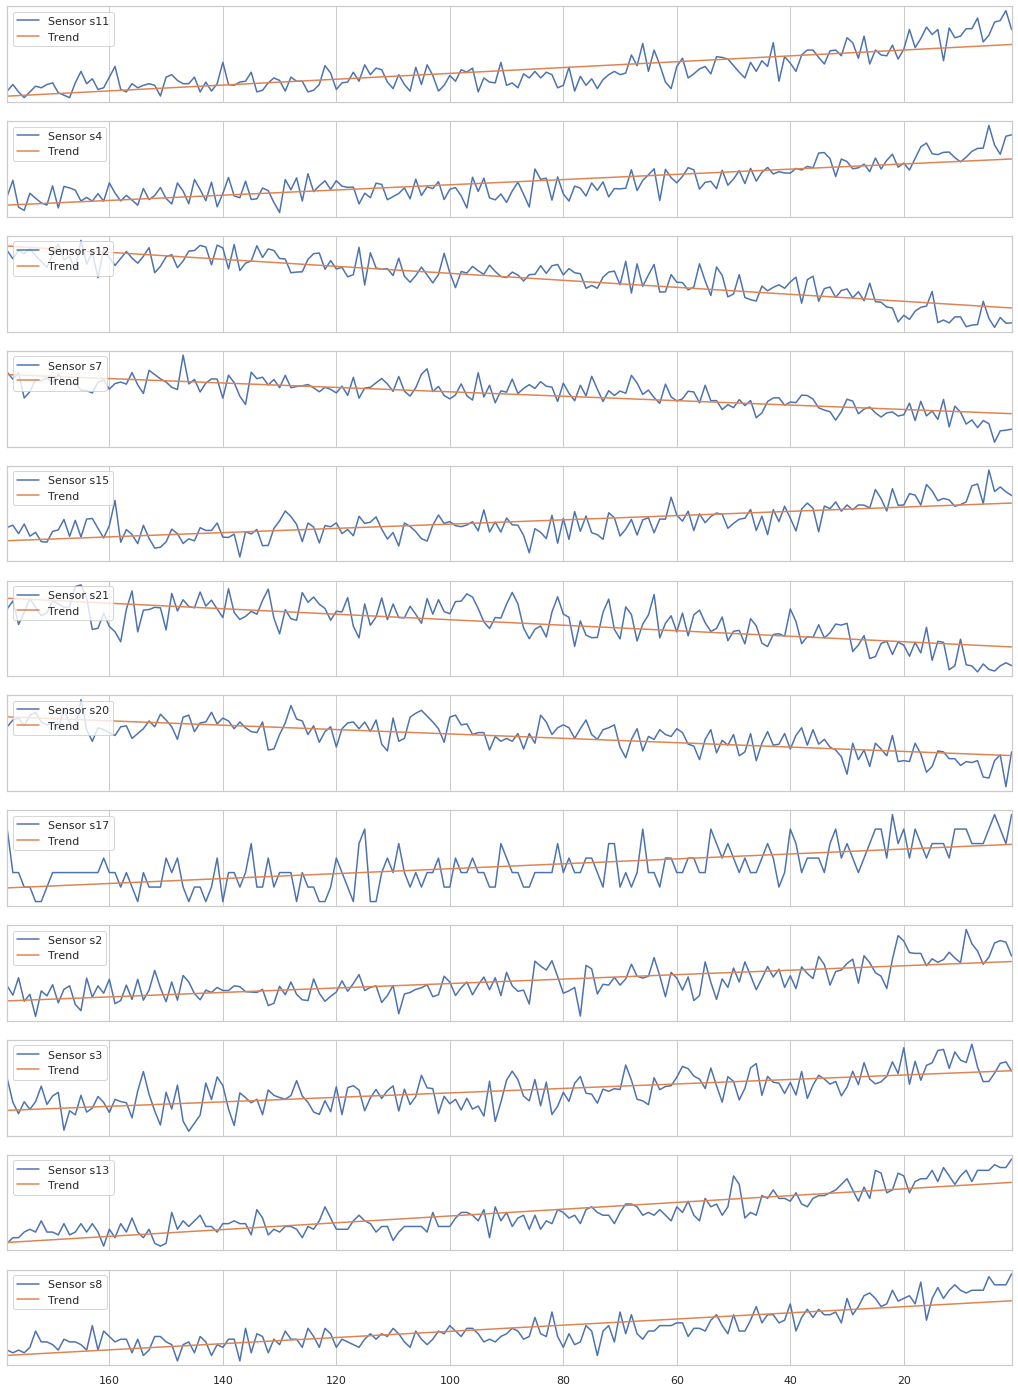

In [16]:
# plotting 
time    = X.flatten()
sensors = y

fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(18, 25), sharex=True)

for col, ax in zip(range(len(sensor_cols)), axes):
    ax.plot()
    
    ax.plot(time, y[:, col], label=f'Sensor {sensor_cols[col]}')
    ax.plot(time, y_hat[:, col], label='Trend')
    
    ax.set_xlim(time[0], 1)
    ax.get_yaxis().set_visible(False)
    ax.legend(loc='upper left')

### Find slopes for all engines

In [17]:
def get_training_data(dataframe, engine_id, sensor_cols):
    # X data
    X = dataframe.loc[engine_id, 'rul'].values
    X = X.reshape(-1, 1)
    
    # y data
    y = dataframe.loc[engine_id, sensor_cols].values
    
    return (X, y)

In [18]:
def slopes_of_engine(X, y):
    """
    Fit a linear model on the sensor values of one engine
    """
    # Create a linear model
    linear_model = LinearRegression()
    
    # Fit the model
    linear_model.fit(X, y)
    
    # Get slopes
    slopes = linear_model.coef_[:,0]
    
    return slopes

#### Example of engine 1

In [19]:
X, y = get_training_data(df_train_norm, 1, sensor_cols)
slopes_of_engine(X, y)

array([-0.0152131 , -0.01411821,  0.01527418,  0.01472885, -0.01184386,
        0.0132954 ,  0.01212988, -0.01174245, -0.01214402, -0.00987553,
       -0.01588666, -0.01436245])

#### Get slopes of all engines

In [20]:
def slopes_all_engine(dataframe, sensor_cols):
    """
    Get the sensor slopes of all engines
    """
    engine_slopes = {}
    
    for engine_id in dataframe.index.unique():
        X, y = get_training_data(df_train, engine_id, sensor_cols)
        slopes = slopes_of_engine(X, y)
        
        engine_slopes[engine_id] = slopes
        
    return engine_slopes
        
engine_slopes = slopes_all_engine(df_train, sensor_cols)

In [21]:
df_engine_slopes = pd.DataFrame(engine_slopes).T

df_engine_slopes.columns = sensor_cols
df_engine_slopes.index.name = 'engine_id'

df_engine_slopes.head()

,s11,s4,s12,s7,s15,s21,s20,s17,s2,s3,s13,s8
engine_id,,,,,,,,,,,,
1,-0.004066,-0.127025,0.011306,0.013083,-0.000444,0.001444,0.002193,-0.018209,-0.006074,-0.060471,-0.001153,-0.001028
2,-0.003025,-0.097428,0.007948,0.009111,-0.000399,0.001078,0.001844,-0.014438,-0.005309,-0.058401,-0.000618,-0.000595
3,-0.003767,-0.131191,0.008516,0.010185,-0.000532,0.001426,0.002293,-0.021229,-0.006066,-0.085967,-0.000375,-0.000402
4,-0.003057,-0.097852,0.006927,0.008839,-0.000422,0.001122,0.001984,-0.019860,-0.004948,-0.066386,-0.000223,-0.000218
5,-0.003089,-0.105127,0.008026,0.009382,-0.000370,0.001119,0.001874,-0.016325,-0.005021,-0.066011,-0.000539,-0.000530


#### Sensor with highest slopes
Sensors with higher slopes make it easier to distinguish the different ruls.

In [22]:
high_trend_sensors = df_engine_slopes.mean(axis=0).abs().sort_values(ascending=False).index.tolist()
high_trend_sensors

['s4', 's3', 's17', 's7', 's12', 's2', 's11', 's20', 's21', 's13', 's8', 's15']

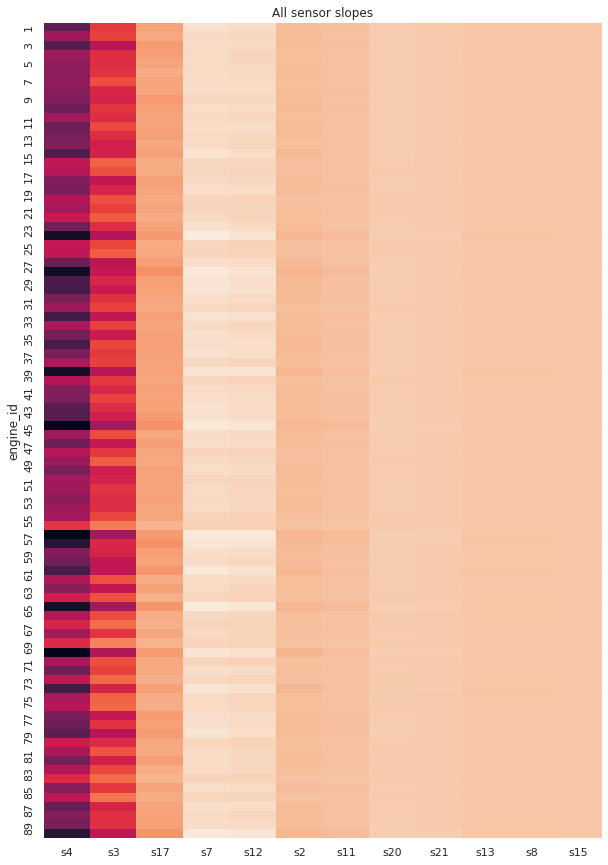

In [23]:
plt.figure(figsize=(10, 15))
sns.heatmap(df_engine_slopes[high_trend_sensors], cbar=False)
plt.title('All sensor slopes');

### PCA on the sensor slopes

In [24]:
from sklearn.decomposition import PCA

In [25]:
top_n_sensors = 6
n_components  = 3

high_trend = df_train_norm[high_trend_sensors[:top_n_sensors]]

pca = PCA(n_components=n_components)
pca.fit(high_trend);

#### Variance explained by the different pca components

In [26]:
var_explained = sum((100 * pca.explained_variance_ratio_).tolist())
round(var_explained, 2)

88.36

#### Only select top n sensors

In [27]:
sensors_pca = pca.transform(high_trend)
sensors_pca.shape

(18380, 3)

In [28]:
sensors_pca[:5]

array([[-2.06129736,  0.85877166, -0.49074592],
       [-1.61779125,  0.93130613, -0.13639162],
       [-2.47552475,  0.61613067,  1.08967917],
       [-2.75105078, -0.36364042, -0.05714553],
       [-1.66926047, -0.69411773, -0.41511569]])

#### Join the pca with the original dataframe

In [29]:
matrix = np.column_stack([df_train_norm[['cycle', 'rul']].values, sensors_pca])

df_pca = pd.DataFrame(matrix, index=df_train.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])
df_pca.head()

,cycle,rul,pca1,pca2,pca3
engine_id,,,,,
1,1.0,192.0,-2.061297,0.858772,-0.490746
1,2.0,191.0,-1.617791,0.931306,-0.136392
1,3.0,190.0,-2.475525,0.616131,1.089679
1,4.0,189.0,-2.751051,-0.363640,-0.057146
1,5.0,188.0,-1.669260,-0.694118,-0.415116


### Sensor fusing

In [30]:
high_rul = 250
low_rul  = 5
ruls     = df_pca['rul'].values

In [31]:
idx_high_health = [ruls > high_rul][0]
idx_low_health  = [ruls <= low_rul][0]

In [32]:
# PCA to perform sensor fusing on
high_health_data = df_pca.loc[idx_high_health, ['pca1', 'pca2', 'pca3']]
low_health_data  = df_pca.loc[idx_low_health, ['pca1', 'pca2', 'pca3']]

# concatenate high HI and Low HI data
X_health = np.concatenate((high_health_data, low_health_data),axis=0)

# target for the fused signal [ just 0 or 1 for failed ans healthy]
y_one = np.ones(high_health_data.shape[0])
y_zero = np.zeros(low_health_data.shape[0])

# concatenate high HI and Low HI target
y_health = np.concatenate((y_one, y_zero),axis=0)

In [33]:
X_health[:5]

array([[-3.53441269,  0.28836692, -0.05628205],
       [-3.38003821,  0.70629002, -0.70699197],
       [-3.59648401,  1.20819255, -0.45264335],
       [-3.4127827 ,  0.41992825, -0.26132903],
       [-3.92414737, -0.18715612,  0.32544327]])

In [34]:
y_health[:5]

array([1., 1., 1., 1., 1.])

In [35]:
# Linear regression
linear_model = LinearRegression()
linear_model.fit(X_health, y_health)

# Logistic regression
logistic_model = LogisticRegression(solver='liblinear')
logistic_model.fit(X_health, y_health);

#### Predict the health index for a certain engine

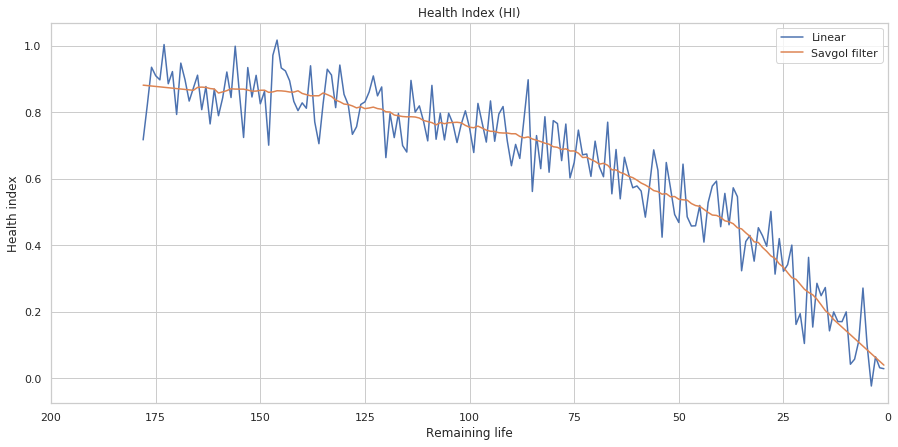

In [38]:
def health_index_of_engine(dataframe, engine_id, model):
    engine_sensors = dataframe.loc[engine_id, ['pca1', 'pca2', 'pca3']]
    engine_rul     = dataframe.loc[engine_id, 'rul']

    # Predict the health index
    health_pred = model.predict(engine_sensors)
    
    return (engine_rul, health_pred)

x, y = health_index_of_engine(df_pca, ENGINE_ID, linear_model)

# Plot the health index
fig = plt.figure(figsize=(15,7))
plt.plot(x, y, label='Linear')
plt.plot(x, savgol_filter(y, 25, 1), label='Savgol filter')
plt.title('Health Index (HI)')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(200, 0)
plt.legend();

#### Plot health indices for all engines

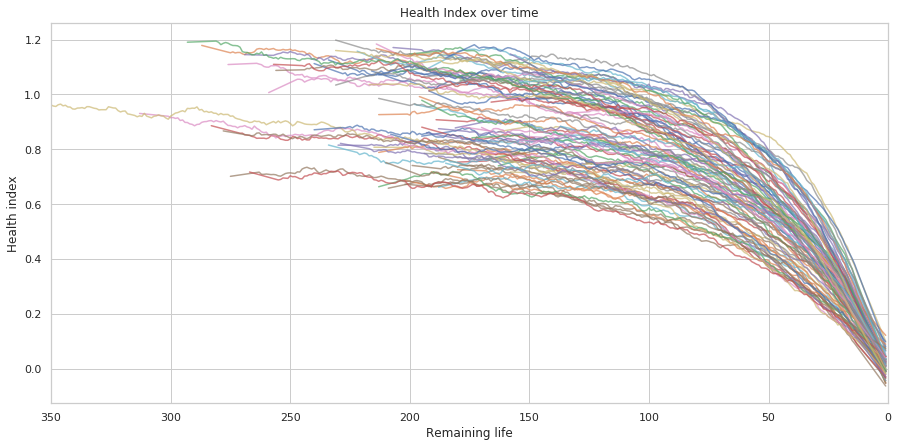

In [39]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id in df_pca.index.unique():
    x, y = health_index_of_engine(df_pca, engine_id, linear_model)

    plt.plot(x, savgol_filter(y, 25, 1), label='Savgol filter', alpha=0.7)
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(350, 0);

### Fitting the health index curve

In [40]:
from scipy.optimize import curve_fit

In [41]:
df_health_index = df_pca.copy()

df_health_index['hi_pred'] = linear_model.predict(df_health_index[['pca1', 'pca2', 'pca3']])

df_health_index.head()

,cycle,rul,pca1,pca2,pca3,hi_pred
engine_id,,,,,,
1,1.0,192.0,-2.061297,0.858772,-0.490746,0.986230
1,2.0,191.0,-1.617791,0.931306,-0.136392,0.925984
1,3.0,190.0,-2.475525,0.616131,1.089679,1.046315
1,4.0,189.0,-2.751051,-0.363640,-0.057146,1.090202
1,5.0,188.0,-1.669260,-0.694118,-0.415116,0.945858


In [42]:
def exp_func(x, a, b):
    return a * (np.exp(b * -x)-1)

x = df_health_index.loc[ENGINE_ID, 'rul']
y = savgol_filter(df_health_index.loc[ENGINE_ID, 'hi_pred'], 25, 1)

popt, _ = curve_fit(exp_func, x, y)
popt

array([-0.92014332,  0.01776918])

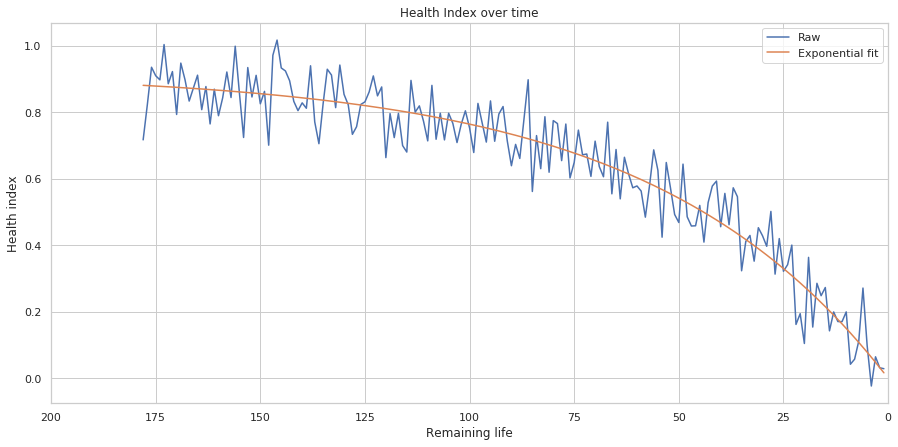

In [43]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

x, y = health_index_of_engine(df_pca, ENGINE_ID, linear_model)

plt.plot(x, y, label='Raw')
plt.plot(x, exp_func(x, *popt), label='Exponential fit')
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(200, 0)
plt.legend();

In [44]:
def find_exp_params(dataframe):
    exp_params = np.zeros((dataframe.index.nunique(), 2))
    
    # Loop through the engines
    for idx, (engine_id, engine) in enumerate(dataframe.groupby('engine_id')):
        x = engine['rul']
        y = savgol_filter(engine['hi_pred'], 25, 1)

        popt, _ = curve_fit(exp_func, x, y)
        
        exp_params[idx, :] = popt
        
    return exp_params
        
exp_params = find_exp_params(df_health_index)
exp_params[:5]

array([[-1.03913244,  0.01885149],
       [-1.20410417,  0.01264254],
       [-1.05088079,  0.02661706],
       [-0.90931573,  0.02659976],
       [-1.18615481,  0.01377137]])

#### Add the exponential fits to the dataframe

In [45]:
def get_exponential(timestep):
    return exp_func(timestep['rul'], *exp_params[timestep.name-1, :])

df_health_index['exp'] = df_health_index.apply(get_exponential, axis=1)
df_health_index.head()

,cycle,rul,pca1,pca2,pca3,hi_pred,exp
engine_id,,,,,,,
1,1.0,192.0,-2.061297,0.858772,-0.490746,0.986230,1.011287
1,2.0,191.0,-1.617791,0.931306,-0.136392,0.925984,1.010758
1,3.0,190.0,-2.475525,0.616131,1.089679,1.046315,1.010218
1,4.0,189.0,-2.751051,-0.363640,-0.057146,1.090202,1.009667
1,5.0,188.0,-1.669260,-0.694118,-0.415116,0.945858,1.009107


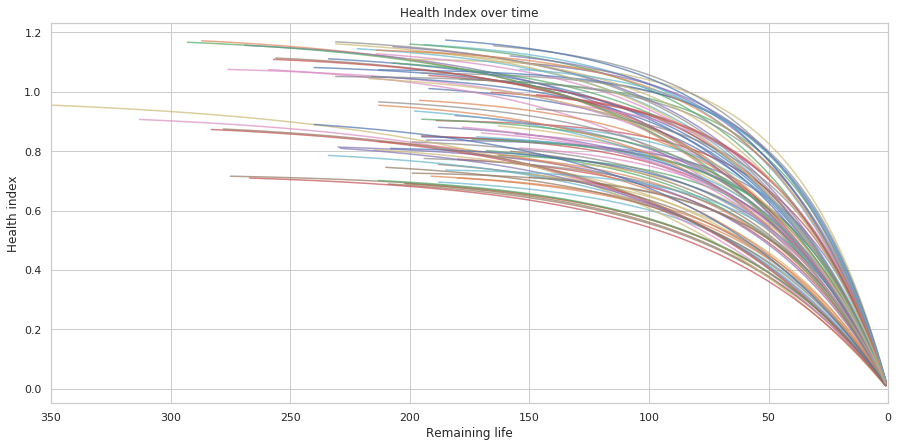

In [46]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id, engine in df_health_index.groupby('engine_id'):
    x = engine['rul']
    y = engine['exp']

    plt.plot(x, y, label='Savgol filter', alpha=0.7)
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(350, 0);